In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import torch
import torch.nn as nn
import matplotlib.lines as mlines
import corner
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import sys
sys.path.append('../../')
import data.datasets as datasets
from models.losses import SupervisedSimCLRLoss
#from models.networks import CustomEfficientNet
from models.networks import MLP
from models.litmodels import SimCLRModel
import data.data_utils as dutils

In [125]:
# --- Selection & Mass Calculations ---

def compute_mass(E, px, py, pz):
    return np.sqrt(np.maximum(E**2 - px**2 - py**2 - pz**2, 0))

def compute_pair_mass(e1, px1, py1, pz1, e2, px2, py2, pz2):
    E = e1 + e2
    px = px1 + px2
    py = py1 + py2
    pz = pz1 + pz2
    return np.sqrt(np.maximum(E**2 - px**2 - py**2 - pz**2, 0))

def compute_m4l(E, px, py, pz):
    E_tot = np.sum(E, axis=1)
    px_tot = np.sum(px, axis=1)
    py_tot = np.sum(py, axis=1)
    pz_tot = np.sum(pz, axis=1)
    return np.sqrt(np.maximum(E_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2, 0))


def has_ossf(row):
    leptons = [row[f'PID{i}'] for i in range(1, 5)]
    for i, j in combinations(range(4), 2):
        pid_i = leptons[i]
        pid_j = leptons[j]
        # Same flavor (abs equal), opposite sign
        if abs(pid_i) == abs(pid_j) and pid_i * pid_j < 0:
            return True
    return False

def has_z_candidate(row):
    for i, j in combinations(range(1, 5), 2):
        pid_i = row[f'PID{i}']
        pid_j = row[f'PID{j}']
        if abs(pid_i) == abs(pid_j) and pid_i * pid_j < 0:
            mll = compute_pair_mass(
                row[f'E{i}'], row[f'px{i}'], row[f'py{i}'], row[f'pz{i}'],
                row[f'E{j}'], row[f'px{j}'], row[f'py{j}'], row[f'pz{j}']
            )
            if 60 < mll < 120:
                return True
    return False

def select_higgs_candidates(df):
    E  = df[['E1', 'E2', 'E3', 'E4']].values
    px = df[['px1', 'px2', 'px3', 'px4']].values
    py = df[['py1', 'py2', 'py3', 'py4']].values
    pz = df[['pz1', 'pz2', 'pz3', 'pz4']].values
    df['m4l'] = compute_m4l(E, px, py, pz)
    
    df = df[df.apply(has_ossf, axis=1)]
    df = df[df.apply(has_z_candidate, axis=1)]
    df = df[(df['m4l'] > 70) & (df['m4l'] < 180)]
    return df


def pt(px, py):
    return np.sqrt(px**2 + py**2)

def find_ossf_pairs(row):
    """Find all OSSF lepton pairs. Return list of (i, j) indices."""
    pairs = []
    for i, j in combinations(range(1, 5), 2):
        pid_i = row[f'PID{i}']
        pid_j = row[f'PID{j}']
        if abs(pid_i) == abs(pid_j) and pid_i * pid_j < 0:
            pairs.append((i, j))
    return pairs

def select_higgs_candidates(df):
    # Invariant mass
    E = df[[f'E{i}' for i in range(1, 5)]].values
    px = df[[f'px{i}' for i in range(1, 5)]].values
    py = df[[f'py{i}' for i in range(1, 5)]].values
    pz = df[[f'pz{i}' for i in range(1, 5)]].values
    df['m4l'] = compute_m4l(E, px, py, pz)

    selected_rows = []

    for idx, row in df.iterrows():
        ossf_pairs = find_ossf_pairs(row)

        # Require ≥2 OSSF pairs
        if len(ossf_pairs) < 2:
            continue

        # Compute invariant masses for all OSSF pairs
        pair_masses = []
        for i, j in ossf_pairs:
            mll = compute_pair_mass(
                row[f'E{i}'], row[f'px{i}'], row[f'py{i}'], row[f'pz{i}'],
                row[f'E{j}'], row[f'px{j}'], row[f'py{j}'], row[f'pz{j}']
            )
            pair_masses.append(((i, j), mll))

        # Sort to find Z1 (closest to Z mass)
        pair_masses.sort(key=lambda x: abs(x[1] - 91.2))
        (i1, j1), mZ1 = pair_masses[0]
        used_indices = {i1, j1}

        # Find next OSSF pair not overlapping Z1
        mZ2 = None
        for (i, j), mass in pair_masses[1:]:
            if i not in used_indices and j not in used_indices:
                mZ2 = mass
                break

        if mZ2 is None:
            continue

        # ChatGPT (loose mode)
        #if not (70 < mZ1 < 110):
        #    continue
        #if not (4 < mZ2 < 120):
        #    continue

        #CMS
        if not (50 < mZ1 < 120):
            continue
        if not (12 < mZ2 < 120):
            continue

        # Loosened lepton pT cuts
        pts = [pt(row[f'px{i}'], row[f'py{i}']) for i in range(1, 5)]
        pts.sort(reverse=True)
        #if not (pts[0] > 10 and pts[1] > 5 and pts[2] > 5 and pts[3] > 5): #ChatGPT (Loose mode)
        if not (pts[0] > 20 and pts[1] > 10 and pts[2] > 5 and pts[3] > 5): #CMS
            continue
        
        # 4l mass window
        if not (70 < row['m4l'] < 180):
            continue

        selected_rows.append(row)

    return pd.DataFrame(selected_rows)

# --- Load and Process Datasets ---
def load_sample(filename, xsec, ngen, lumi):
    df = pd.read_csv(filename)
    df = select_higgs_candidates(df)
    weight = (xsec * lumi) / ngen if ngen > 0 else 0
    df['weight'] = weight
    print(filename,len(df))
    return df['m4l'].values, df['weight'].values


MC/zzto4e2012.csv 16367
MC/zzto2mu2e2012.csv 13554
MC/zzto4mu2012.csv 29684
MC/dy50_2012.csv 3
MC/zzto4e2011.csv 22002
MC/zzto2mu2e2011.csv 17019
MC/zzto4mu2011.csv 34129
MC/ttbar2011.csv 20
MC/dy50_2011.csv 10


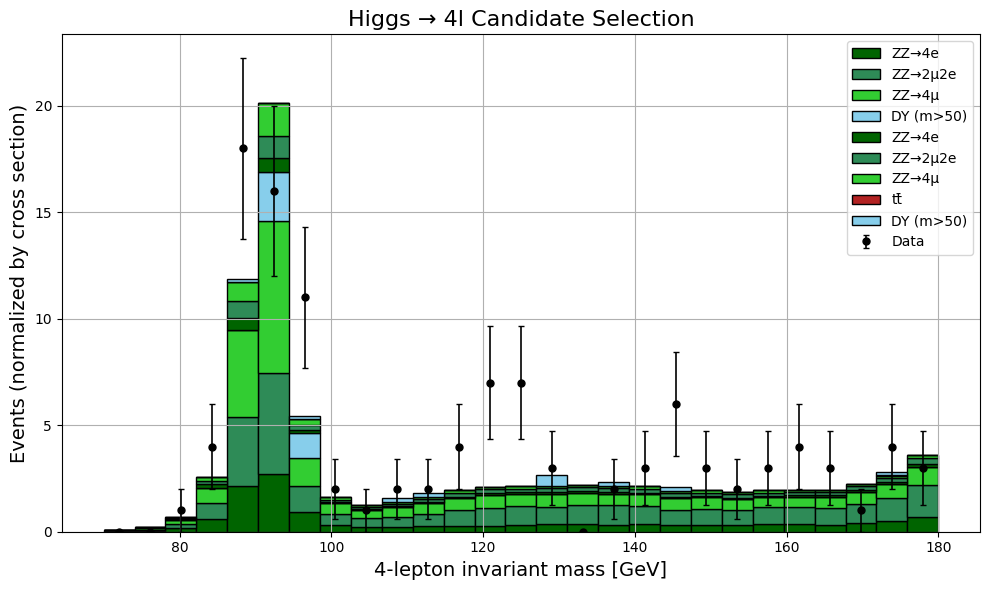

In [126]:
# --- Parameters: cross sections, event counts, lumi ---
lumi = 11580. 
xszzto4e  = 0.107
xszzto4mu = 0.107
xszzto2mu2e = 0.249
xsttbar   = 200.
xsdy50    = 2955.
xsdy1050  = 10.742

nzzto4mu   = 1499064
nzzto4e    = 1499093
nzzto2mu2e = 1497445
nttbar     = 6423106
ndy50      = 29426492
ndy1050    = 6462290

# --- Load all MC samples ---
hist_data = []
labels = []
colors = []

sample_info_12 = {
    "ZZ→4e":     ("MC/zzto4e2012.csv",     "darkgreen",  xszzto4e,     nzzto4e),
    "ZZ→2μ2e":   ("MC/zzto2mu2e2012.csv",  "seagreen",   xszzto2mu2e,  nzzto2mu2e),
    "ZZ→4μ":     ("MC/zzto4mu2012.csv",    "limegreen",  xszzto4mu,    nzzto4mu),
#    "tt̄":        ("MC/ttbar2012.csv",      "firebrick",  xsttbar,      nttbar),
    "DY (m>50)": ("MC/dy50_2012.csv",       "skyblue",    xsdy50,       ndy50),
#    "DY (10<m<50)": ("MC/dy1050_2012.csv",  "dodgerblue", xsdy1050,     ndy1050),
}

for label, (file, color, xsec, ngen) in sample_info_12.items():
    m4l, weights = load_sample(file, xsec, ngen, lumi)
    hist_data.append((m4l, weights))
    labels.append(label)
    colors.append(color)

# --- Load data sample ---
df_data = pd.read_csv("Data/clean_data_2012.csv")
df_data = select_higgs_candidates(df_data)
m4l_data_12 = df_data['m4l'].values

lumi = 2330. #11
xszzto4e  = 0.093
xszzto4mu = 0.093
xszzto2mu2e = 0.208
xsttbar   = 19.504
xsdy50    = 2475.
xsdy1050  = 9507.


nzzto4mu   = 1447136
nzzto4e    = 1493308
nzzto2mu2e = 1479879
nttbar     = 9771205
ndy50      = 36408225
ndy1050    = 39909640

sample_info_11 = {
    "ZZ→4e":     ("MC/zzto4e2011.csv",     "darkgreen",  xszzto4e,     nzzto4e),
    "ZZ→2μ2e":   ("MC/zzto2mu2e2011.csv",  "seagreen",   xszzto2mu2e,  nzzto2mu2e),
    "ZZ→4μ":     ("MC/zzto4mu2011.csv",    "limegreen",  xszzto4mu,    nzzto4mu),
    "tt̄":        ("MC/ttbar2011.csv",      "firebrick",  xsttbar,      nttbar),
    "DY (m>50)": ("MC/dy50_2011.csv",       "skyblue",    xsdy50,       ndy50),
#    "DY (10<m<50)": ("MC/dy1050_2011.csv",  "dodgerblue", xsdy1050,     ndy1050),
}

# --- Load data sample ---
df_data = pd.read_csv("Data/clean_data_2011.csv")
df_data = select_higgs_candidates(df_data)
m4l_data = df_data['m4l'].values
m4l_data = np.append(m4l_data,m4l_data_12)

bins = np.linspace(70, 180, 28)  # 2 GeV bin width

for label, (file, color, xsec, ngen) in sample_info_11.items():
    m4l, weights = load_sample(file, xsec, ngen, lumi)
    hist_data.append((m4l, weights))
    labels.append(label)
    colors.append(color)

# --- Plot stacked histogram ---

plt.figure(figsize=(10, 6))
plt.hist(
    [d[0] for d in hist_data],
    bins=bins,
    weights=[d[1] for d in hist_data],
    stacked=True,
    label=labels,
    color=colors,
    edgecolor='black'
)

# --- Bin the data (using same bin edges as MC) ---
counts_data, bin_edges = np.histogram(m4l_data, bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
errors = np.sqrt(counts_data)  # Poisson errors

# --- Plot data with markers + error bars ---
plt.errorbar(
    bin_centers,
    counts_data,
    yerr=errors,
    fmt='o',
    color='black',
    markersize=5,
    label='Data',
    capsize=2,
    elinewidth=1.2
)

plt.xlabel("4-lepton invariant mass [GeV]", fontsize=14)
plt.ylabel("Events (normalized by cross section)", fontsize=14)
plt.title("Higgs → 4l Candidate Selection", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig(“higgs_stacked_histogram.png”)
plt.show()

In [ ]:
# -- Load + compute m4l + optionally include full 4-vectors --
def load_sample_for_pytorch(filename, label_index, include_vectors=False):
    df = pd.read_csv(filename)
    df = select_higgs_candidates(df)

    # Compute m4l from 4-vectors
    E = df[[f'E{i}' for i in range(1, 5)]].values
    px = df[[f'px{i}' for i in range(1, 5)]].values
    py = df[[f'py{i}' for i in range(1, 5)]].values
    pz = df[[f'pz{i}' for i in range(1, 5)]].values
    m4l = compute_m4l(E, px, py, pz).reshape(-1, 1)

    if include_vectors:
        # Flatten all 4-vectors into one feature vector
        vectors = np.hstack([E, px, py, pz])  # shape: [N, 16]
        features = np.hstack([vectors, m4l])  # shape: [N, 17]
    else:
        features = m4l  # shape: [N, 1]

    labels = np.full((features.shape[0],), label_index, dtype=np.int64)
    return torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)


input_dim=16
sample_info = {
    "ZZ→4e":     ("MC/zzto4e2011.csv",     "darkgreen",  xszzto4e,     nzzto4e, 0),
    "ZZ→2μ2e":   ("MC/zzto2mu2e2011.csv",  "seagreen",   xszzto2mu2e,  nzzto2mu2e,1),
    "ZZ→4μ":     ("MC/zzto4mu2011.csv",    "limegreen",  xszzto4mu,    nzzto4mu,2),
    "tt̄":        ("MC/ttbar2011.csv",      "firebrick",  xsttbar,      nttbar,3),
    "DY (m>50)": ("MC/dy50_2011.csv",       "skyblue",    xsdy50,       ndy50,4),
    "DY (10<m<50)": ("MC/dy1050_2011.csv",  "dodgerblue", xsdy1050,     ndy1050,5),
}

# -- Process all samples --
all_features = []
all_labels = []

for name, (csv_file, _, _, _, label_idx) in samples.items():
    features, labels = load_sample_for_pytorch(csv_file, label_idx, include_vectors=True)
    all_features.append(features)
    all_labels.append(labels)

# -- Concatenate into single dataset --
X = torch.cat(all_features, dim=0)
y = torch.cat(all_labels, dim=0)
dataset = TensorDataset(X, y)

# --- Define the train/test split ratio ---
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# --- Randomly split the dataset ---
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size=1000
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#now contrastive model
hidden_dims= [128,64,32,16]
embed_dim  = 4 #not making it smaller than input space
temp = 0.01
embedder   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model = SimCLRModel(embedder, projector)
criterion = SupervisedSimCLRLoss(temperature=temp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-3)

In [ ]:
# Training loop
num_epochs = 10
batch_size = 1000
# Dataloaders
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader,model,criterion,optimizer)

In [ ]:
output = []
labels =tjds.test_labels.int()
labels1=tjds.true_labels.int()
with torch.no_grad():
    output  = (model(tjds.test_data.float(),embed=True))
    output1 = (model(tjds.true_data.float(),embed=True))

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0].numpy(),fig=fig,color="C0", label='background')
corner.corner(output[labels==1].numpy(),fig=fig,color="C1", label='signal 1')
corner.corner(output[labels==2].numpy(),fig=fig,color="C2", label='signal 2')
corner.corner(output[labels==3].numpy(),fig=fig,color="C3", label='signal 3')
corner.corner(output1[labels1==3].numpy(),fig=fig,color="C3", label='data signal 4')
corner.corner(output1[labels1==0].numpy(),fig=fig,color="C0", label='data background')
corner.corner(output1[labels1==1].numpy(),fig=fig,color="C1", label='data signal 1')
corner.corner(output1[labels1==2].numpy(),fig=fig,color="C2", label='data signal 2')
corner.corner(output1[labels1==3].numpy(),fig=fig,color="C3", label='data signal 3')
corner.corner(output1[labels1==3].numpy(),fig=fig,color="C3", label='data signal 4')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C1", label='signal 1'),
            mlines.Line2D([], [], color="C2", label='signal 2'),
            mlines.Line2D([], [], color="C3", label='signal 3'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()